In [473]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py, matplotlib
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact
import glob, re
from pprint import pprint
import matplotlib.gridspec as gridspec
from scipy.constants import hbar, electron_mass as m_e, elementary_charge as q_e

matplotlib.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [3]:
def load_dsp(df, line_nr=[91, 92, 93, 90]):
    """
    Loads a .dsp file from Maxwell and extracts elements, nodes and the solution at the nodes.
    For this code to work, the data must have been saved as a dsp file, with only a single plot in the Fields tab.
    :param df: File path of the data file
    :return: elements, node, element solution, bounding box
    """
    with open(df, 'r') as myfile:
        data = myfile.readlines()

    # The important data is stored on line numbers 91-93.
    # Line 91: Elements: Each element is composed of 6 nodes. Each sequence of 2,3,3,0,6 is followed by 6 points, which will
    # make up a single element. First 2 entries are diagnostic info.
    # Line 92: Node coordinates. One node coordinate has 3 entries: x, y, z
    # Line 93: Solution on each node. First 3 entries are diagnostic info.

    elements = np.array(re.findall(r"\((.*?)\)", data[line_nr[0]-1])[0].split(', '), dtype=int)
    nodes = np.array(re.findall(r"\((.*?)\)", data[line_nr[1]-1])[0].split(', '), dtype=float)
    elem_solution = np.array(re.findall(r"\((.*?)\)", data[line_nr[2]-1])[0].split(', '), dtype=float)

    nodes = nodes.reshape((int(nodes.shape[0]/3), 3))

#     line_nr = 90
    bounding_box = np.array(re.findall(r"\((.*?)\)", data[line_nr[3]-1])[0].split(', '), dtype=float)

    return elements, nodes, elem_solution[3:], bounding_box

In [128]:
def analyze_sweet_spot(datapath, name, d0, xzoom=None, yzoom=None):
    yeval = np.linspace(-1., 2., 251)
    xeval = anneal.construct_symmetric_y(-2.5, 401)

    fig = plt.figure(figsize=(4., 3.))
    common.configure_axes(13)

    
    df = os.path.join(datapath, "%s" % name)

    elements, nodes, solution, bbox = load_dsp(df)
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, solution)
    xcenter = np.mean(bbox[0:2])
    ycenter = np.mean(bbox[2:4])
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                         plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False, plot_data=0)

    # Mirror around the x-axis
    ysize, xsize = np.shape(Uinterp)
    Uinterp_symmetric = np.zeros((ysize, 2 * xsize))
    Uinterp_symmetric[:, :xsize] = Uinterp
    Uinterp_symmetric[:, xsize:] = Uinterp[:, ::-1]

    y_symmetric = np.zeros((ysize, 2 * xsize))
    y_symmetric[:, :xsize] = yinterp
    y_symmetric[:, xsize:] = yinterp

    x_symmetric = np.zeros((ysize, 2 * xsize))
    x_symmetric[:, :xsize] = xinterp
    x_symmetric[:, xsize:] = -xinterp[:, ::-1]

    fig = plt.figure(figsize=(5., 3.))
    plt.pcolormesh(x_symmetric, y_symmetric, Uinterp_symmetric, cmap=plt.cm.GnBu)
    #     plt.title(r"$h$ = %s $\mu$m" % bbox[4])
    plt.xlabel(r"$y$ (%sm)" % (chr(956)))
    plt.ylabel(r"$z$ (%sm)" % (chr(956)))

    anneal.draw_from_dxf(os.path.join(datapath, name[:-4]+'.dxf'), color='k', lw=0.5)
    plt.xlim(np.min(x_symmetric), np.max(x_symmetric))
    plt.ylim(np.min(y_symmetric), np.max(y_symmetric))
    plt.colorbar()
        
    # Determine helium level to find electron position
#     d0 = 1.1E-6 + 80E-9
    rho = 145
    g = 9.81
    h = 10E-3
    sigma = 3.78E-4
    w = 3.5E-6

    t_He = d0 - rho * g * h * w ** 2/ (8 * sigma)

    print("We estimate the electron is roughly ", (d0 - t_He) * 1E9, " nm below the ground plane")

    zrange = np.linspace(0.8, 1.5, 61)
    fe = list()

    fig = plt.figure(figsize=(7.,3.))
    plt.subplot(121)

    for k, z in enumerate(zrange):
        idx = common.find_nearest(yeval, z)
        potential_cut = -Uinterp_symmetric[idx, :]
        plt.plot(x_symmetric[idx, :], potential_cut, color='k')

        fr, ferr = kfit.fit_parabola(x_symmetric[idx, :], potential_cut, domain=[-0.5, 0.5],
                                     fitparams=[np.min(potential_cut), 0.5, 0.0], verbose=False)

        xplot = np.linspace(-0.5, 0.5)
        plt.plot(xplot, kfit.parabolafunc(xplot, *fr), '-r', color=plt.cm.viridis(float(k / len(zrange))))

        fe.append(1 / (2 * np.pi * 1E9) * np.sqrt(2 * q_e * fr[1] * 1E12 / m_e))

    plt.xlabel(r"$y$ (%sm)" % (chr(956)))
    plt.xlim(np.min(x_symmetric[idx, :]), np.max(x_symmetric[idx, :]))
    plt.ylabel(r"Electrostatic potential (eV)")

    Vres = np.linspace(0, 1, 1E3)

    plt.subplot(122)
    plt.plot(Vres, np.sqrt(Vres) * np.array(fe[common.find_nearest(zrange, t_He)]))
    plt.hlines(6.5, 0, 1, linestyles='-', color='k')
    plt.xlabel("$V_\mathrm{res}$")
    plt.ylabel("$f_e$ (GHz)")
    plt.xlim(0, 1)
    plt.ylim(0, np.max(fe))

    fig.tight_layout()

    fig = plt.figure(figsize=(5.,3.))
    gs = gridspec.GridSpec(1, 2, width_ratios=[0.75, 0.25], wspace=0.05)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ax1.pcolormesh(x_symmetric, y_symmetric, Uinterp_symmetric, cmap=plt.cm.GnBu)
    #     plt.title(r"$h$ = %s $\mu$m" % bbox[4])
    ax1.set_xlabel(r"$y$ (%sm)" % (chr(956)))
    ax1.set_ylabel(r"$z$ (%sm)" % (chr(956)))

    anneal.draw_from_dxf(os.path.join(datapath, name[:-4]+'.dxf'), ax=ax1, color='k', lw=0.5)
    ax1.set_xlim(np.min(x_symmetric), np.max(x_symmetric))
    ax1.set_ylim(np.min(y_symmetric), np.max(y_symmetric))

    ax2.plot(fe, zrange, '-r')
    ax2.set_xlabel("$f_e$ (GHz)")
    ax2.set_ylim(ax1.get_ylim())
    # ax2.set_yticklabels([])
    ax2.yaxis.tick_right()

    # Determine the sweet spot
    z_sweet_spot = zrange[np.argmax(fe)]

    ax1.hlines(z_sweet_spot, np.min(x_symmetric), np.max(x_symmetric), linestyles='--', color='gray', lw=1)
    ax2.hlines(z_sweet_spot, np.min(fe), np.max(fe), linestyles='--', color='gray', lw=1)

    ax1.hlines(t_He * 1E6, np.min(x_symmetric), np.max(x_symmetric), linestyles='--', color='black', lw=1)
    ax2.hlines(t_He * 1E6, np.min(fe), np.max(fe), linestyles='--', color='black', lw=1)

    if yzoom is not None:
        ax1.set_ylim(yzoom)
        ax2.set_ylim(yzoom)
    if xzoom is not None:
        ax2.set_xlim(xzoom)

    print("Sweet spot coordinate is z = ", z_sweet_spot, "um")
    print("Electron is ", (t_He * 1e6 - z_sweet_spot)*1e3, "nm above the sweet spot")

## M018 data for reference 

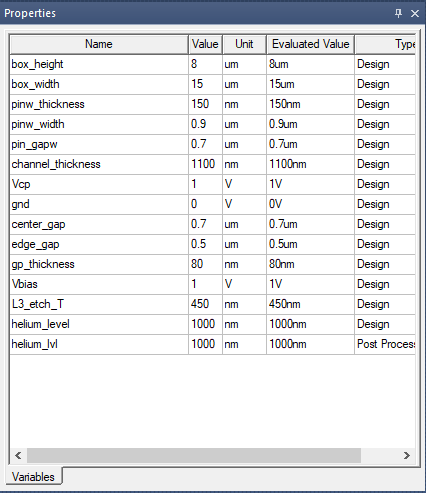

In [129]:
from IPython.display import Image
Image(filename=r"S:\_Data\190321 - EonHe Sweet Spot Simulations\Resonator simulation results\M018_2D_Reference_DC_Potential_Settings.png")

We estimate the electron is roughly  57.62239583333337  nm below the ground plane


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Sweet spot coordinate is z =  1.1675 um
Electron is  -45.1223958333 nm above the sweet spot


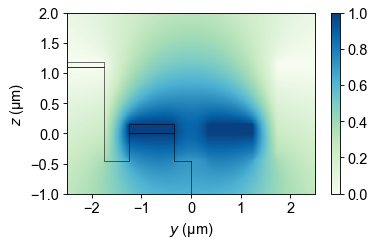

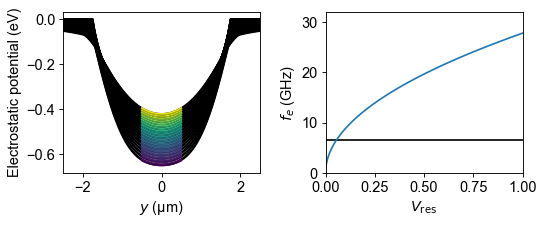

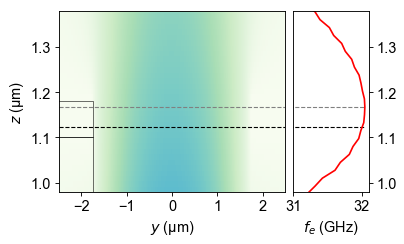

In [147]:
datapath = r"S:\_Data\190321 - EonHe Sweet Spot Simulations\Resonator simulation results"
name = r"00_M018_2D_Reference_DC_Potential.dsp"
d0 = 1.1E-6 + 80E-9 # Top of the ground plane
analyze_sweet_spot(datapath, name, d0, xzoom=(31.0, 32.1), yzoom=(d0 * 1E6 - 0.2, d0 * 1E6 + 0.2))

## Small tweaks to M018 to see dependences

### Vary ground plane thickness

We estimate the electron is roughly  57.62239583333337  nm below the ground plane


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Sweet spot coordinate is z =  1.1675 um
Electron is  24.8776041667 nm above the sweet spot


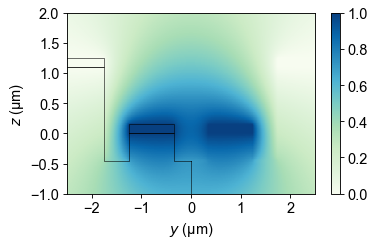

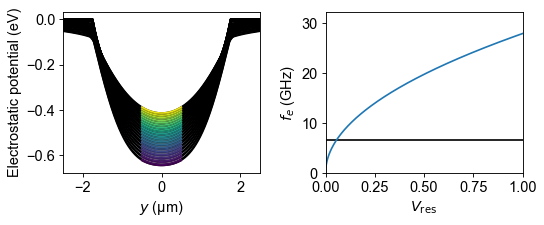

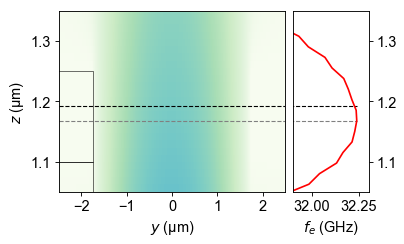

In [138]:
datapath = r"S:\_Data\190321 - EonHe Sweet Spot Simulations\Resonator simulation results"
name = r"01_M018_SmallTweaks_GND_150nm.dsp"
d0 = 1.1E-6 + 150E-9 # Top of the ground plane
analyze_sweet_spot(datapath, name, d0, xzoom=(31.9, 32.3), yzoom=(d0 * 1E6 - 0.2, d0 * 1E6 + 0.1))

### Vary channel height 

We estimate the electron is roughly  57.62239583333337  nm below the ground plane


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Sweet spot coordinate is z =  1.1325 um
Electron is  -210.122395833 nm above the sweet spot


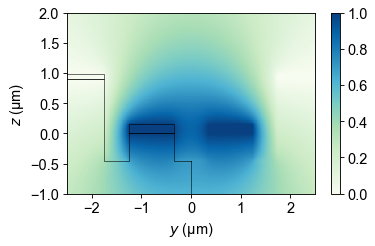

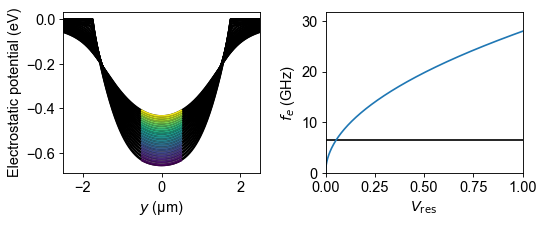

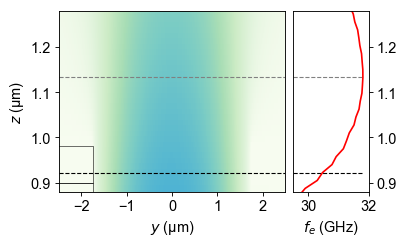

In [137]:
datapath = r"S:\_Data\190321 - EonHe Sweet Spot Simulations\Resonator simulation results"
name = r"02_M018_SmallTweaks_ChannelThick_900nm.dsp"
d0 = 0.9E-6 + 80E-9 # Top of the ground plane
analyze_sweet_spot(datapath, name, d0, xzoom=(29.5, 32.0), yzoom=(d0 * 1E6 - 0.1, d0 * 1E6 + 0.3))

We estimate the electron is roughly  57.62239583333337  nm below the ground plane


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Sweet spot coordinate is z =  1.185 um
Electron is  137.377604167 nm above the sweet spot


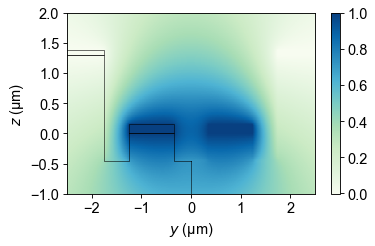

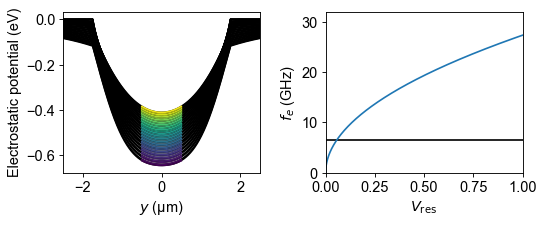

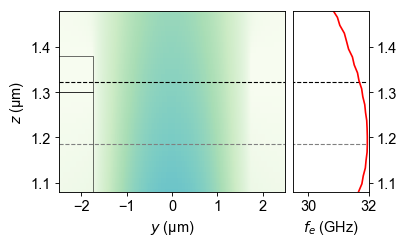

In [141]:
datapath = r"S:\_Data\190321 - EonHe Sweet Spot Simulations\Resonator simulation results"
name = r"03_M018_SmallTweaks_ChannelThick_1300nm.dsp"
d0 = 1.3E-6 + 80E-9 # Top of the ground plane
analyze_sweet_spot(datapath, name, d0, xzoom=(29.5, 32.0), yzoom=(d0 * 1E6 - 0.3, d0 * 1E6 + 0.1))

### Decrease center pin width from 0.9 um to 0.7 um 

We estimate the electron is roughly  57.62239583333337  nm below the ground plane


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Sweet spot coordinate is z =  1.0975 um
Electron is  24.8776041667 nm above the sweet spot


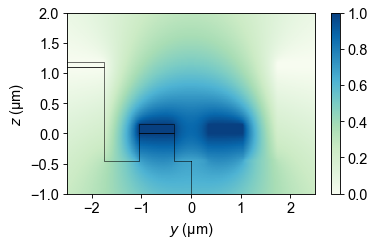

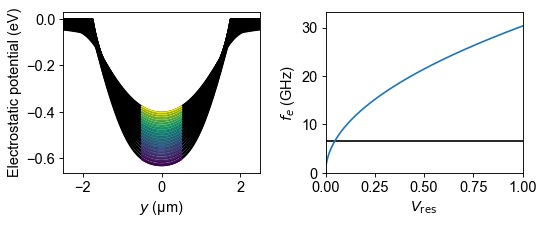

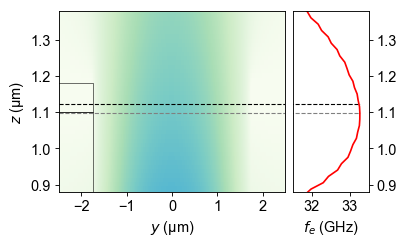

In [148]:
datapath = r"S:\_Data\190321 - EonHe Sweet Spot Simulations\Resonator simulation results"
name = r"04_M018_SmallTweaks_CenterPin_700nm.dsp"
d0 = 1.1E-6 + 80E-9 # Top of the ground plane
analyze_sweet_spot(datapath, name, d0, xzoom=(31.5, 33.5), yzoom=(d0 * 1E6 - 0.3, d0 * 1E6 + 0.2))

### Decrease center pin width from 0.7 um to 0.5 um 

We estimate the electron is roughly  57.62239583333337  nm below the ground plane


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Sweet spot coordinate is z =  0.975 um
Electron is  147.377604167 nm above the sweet spot


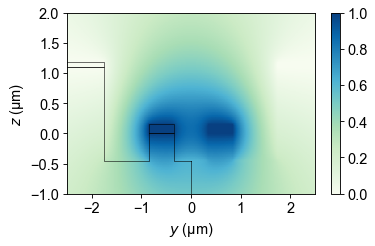

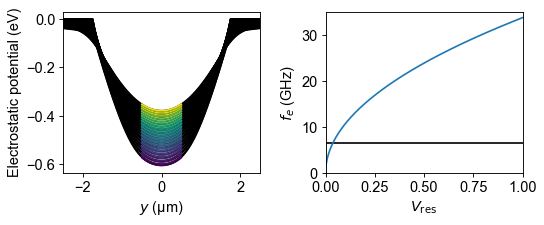

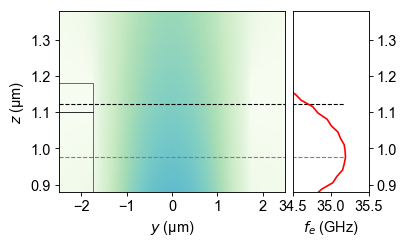

In [152]:
datapath = r"S:\_Data\190321 - EonHe Sweet Spot Simulations\Resonator simulation results"
name = r"06_M018_SmallTweaks_CenterPin_500nm.dsp"
d0 = 1.1E-6 + 80E-9 # Top of the ground plane
analyze_sweet_spot(datapath, name, d0, xzoom=(34.5, 35.5), yzoom=(d0 * 1E6 - 0.3, d0 * 1E6 + 0.2))

### Increase center gap from 0.7 um to 0.9 um

We estimate the electron is roughly  57.62239583333337  nm below the ground plane


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Sweet spot coordinate is z =  1.2025 um
Electron is  -80.1223958333 nm above the sweet spot


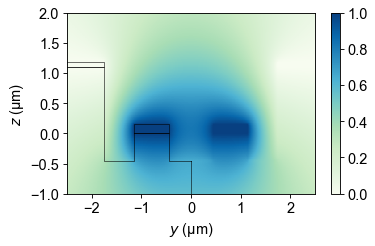

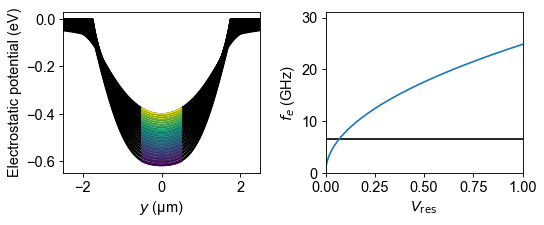

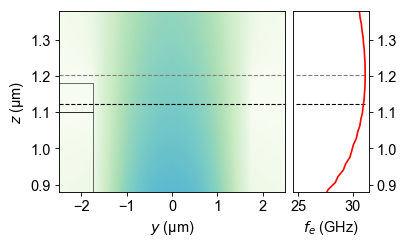

In [143]:
datapath = r"S:\_Data\190321 - EonHe Sweet Spot Simulations\Resonator simulation results"
name = r"05_M018_SmallTweaks_CenterGap_900nm.dsp"
d0 = 1.1E-6 + 80E-9 # Top of the ground plane
analyze_sweet_spot(datapath, name, d0, xzoom=None, yzoom=(d0 * 1E6 - 0.3, d0 * 1E6 + 0.2))

# 2D trap simulations

In [ ]:
from scipy.constants import

In [499]:
def load_ss_data(datapath, name):
    yeval = np.linspace(-.5, 2., 501)
    xeval = np.linspace(-4, 4, 501)

    fig = plt.figure(figsize=(7., 3.))
    common.configure_axes(13)
    
    output = list()

    for k, suffix in enumerate(["Res1V", "Trap1V"]):
        df = os.path.join(datapath, "%s_%s.dsp" % (name, suffix))

        elements, nodes, solution, bbox = load_dsp(df)
        xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, solution)
        xcenter = np.mean(bbox[0:2])
        ycenter = np.mean(bbox[2:4])
        xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                             plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False, plot_data=0)

        x_symmetric, y_symmetric, Uinterp_symmetric = xinterp, yinterp, Uinterp

        plt.subplot(1, 2, k + 1)
        plt.pcolormesh(x_symmetric, y_symmetric, Uinterp_symmetric, cmap=plt.cm.GnBu)
        plt.xlabel(r"$y$ (%sm)" % (chr(956)))
        plt.ylabel(r"$z$ (%sm)" % (chr(956)))

        anneal.draw_from_dxf(os.path.join(datapath, name+'.dxf'), color='k', lw=0.5)
        plt.xlim(np.min(x_symmetric), np.max(x_symmetric))
        plt.ylim(np.min(y_symmetric), np.max(y_symmetric))
        plt.title(suffix)
        plt.colorbar()
        
        output.append({"Type" : suffix, 
                       "x" : xinterp, 
                       "y" : yinterp, 
                       "V" : Uinterp})
    
    fig.tight_layout()
    fig.savefig(os.path.join(datapath, name+"_Potential_Data.png"), dpi=300, bbox_inches='tight', pad_inches=.05)
    return output

def get_resonance_condition(Vres, d0, w, f0, output, Vtrap_sweep=None):
    rho = 145
    g = 9.81
    h = 10E-3
    sigma = 3.78E-4

    t_He = d0 - rho * g * h * w ** 2/ (8 * sigma)

    print("We estimate the electron is roughly ", (d0 - t_He) * 1E9, " nm below the ground plane")

    x = output[0]["x"]
    y = output[0]["y"]
    
    idx = common.find_nearest(y[:, 0], t_He * 1E6)
    print("Evaluating potentials at z = ", y[idx, 0], "um")
    
    res_potential_cut = -output[0]["V"][idx, :]
    trap_potential_cut = -output[1]["V"][idx, :]
    
    if Vtrap_sweep is None:
        Vtrap_sweep = np.linspace(0, Vres, 101)
    
    fe = list()
    
    for Vtrap in Vtrap_sweep:
        Potential = Vres * res_potential_cut + Vtrap * trap_potential_cut
        
        fr, ferr = kfit.fit_parabola(x[idx, :], Potential, domain=[-0.1, 0.1],
                                     fitparams=[np.min(potential_cut), 0.5, 0.0], verbose=False)

        xplot = np.linspace(-0.4, 0.4)
        
        center_idx = common.find_nearest(x[idx, :], 0.0)
        if Potential[center_idx] - np.min(Potential) < 0.0001 and fr[1] > 0:
            fe.append(1 / (2 * np.pi * 1E9) * np.sqrt(2 * q_e * fr[1] * 1E12 / m_e))
        else:
            fe.append(0.0)
    
    Optimum_idx = common.find_nearest(np.array(fe), f0)
    Optimum = Vtrap_sweep[Optimum_idx]
    phi = Vres * res_potential_cut + Optimum * trap_potential_cut
    sensitivity = ( fe[Optimum_idx+1] - fe[Optimum_idx-1] ) / (2 * np.diff(Vtrap_sweep)[0])
    
    fig = plt.figure(figsize=(7., 3.))
    plt.subplot(122)
    electron_freq, anharm = get_anharmonicity(x[idx, :], phi, fitdomain=(-0.4, 0.4), do_plot=1)
    plt.plot(x[idx, :], phi, '-k', lw=1, label=r"$f_e$ = %.1f GHz, $\alpha/2\pi$ = %.0f MHz" % (electron_freq/1e9, anharm/1e6))
    
#     fr, ferr = kfit.fit_parabola(x[idx, :], phi, domain=[-0.4, 0.4], fitparams=[np.min(phi), 0.5, 0.0], verbose=False)
#     plt.plot(x[idx, :], kfit.parabolafunc(x[idx, :], *fr), '-r')
    plt.ylabel("Potential energy (eV)")
    plt.xlabel("x (%sm)" % (chr(956)))
    plt.xlim(np.min(x), np.max(x))
    plt.title("$V_\mathrm{trap}$ = %.3f V"%Optimum)
    plt.legend(loc=0, frameon=False, prop={"size" : 10})
    
    plt.subplot(121)
    plt.plot(Vtrap_sweep, np.array(fe), label="$\partial f_e / \partial V_\mathrm{trap}$ = %.0f MHz/mV" % (sensitivity))
    plt.ylabel("$f_e$ (GHz)")
    plt.xlabel("$V_\mathrm{trap}$ (V)")
    plt.hlines(6.5, np.min(Vtrap_sweep), np.max(Vtrap_sweep), linestyles='-', color='k')
    plt.xlim(np.min(Vtrap_sweep), np.max(Vtrap_sweep))
    plt.legend(loc=0, frameon=False, prop={"size" : 10})
    
    fig.tight_layout()
    return Optimum

def analyze_ss_data(datapath, name, output, d0, w, f0, Vres, Vtrap, xzoom=None, yzoom=None):
    # Determine helium level to find electron position
    rho = 145
    g = 9.81
    h = 10E-3
    sigma = 3.78E-4

    t_He = d0 - rho * g * h * w ** 2/ (8 * sigma)

    print("We estimate the electron is roughly ", (d0 - t_He) * 1E9, " nm below the ground plane")

    x = output[0]["x"]
    y = output[0]["y"]
    
    for k in range(len(output)):
        if k == 0:
            Potential = Vres * output[k]["V"]
        else: 
            Potential += Vtrap * output[k]["V"]
        
    zrange = np.linspace(0.5, 2.0, 1001)
    fe = list()

    fig = plt.figure(figsize=(5.,3.))
    plt.subplot(111)

    for k, z in enumerate(zrange):
        idx = common.find_nearest(y[:, 0], z)
        potential_cut = -Potential[idx, :]
        plt.plot(x[idx, :], potential_cut, color='k')

        center = x[idx, np.argmin(potential_cut)]
        fr, ferr = kfit.fit_parabola(x[idx, :], potential_cut, domain=[center-0.1, center+0.1],
                                     fitparams=[np.min(potential_cut), 0.5, center], verbose=False)

        xplot = np.linspace(center-0.4, center+0.4)
        plt.plot(xplot, kfit.parabolafunc(xplot, *fr), '-r', color=plt.cm.viridis(float(k / len(zrange))))

        fe.append(1 / (2 * np.pi * 1E9) * np.sqrt(2 * q_e * fr[1] * 1E12 / m_e))

    plt.xlabel(r"$y$ (%sm)" % (chr(956)))
    plt.xlim(np.min(x[idx, :]), np.max(x[idx, :]))
    plt.ylabel(r"Electrostatic potential (eV)")
    
    fig = plt.figure(figsize=(5.,3.))
    gs = gridspec.GridSpec(1, 2, width_ratios=[0.75, 0.25], wspace=0.05)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ax1.pcolormesh(x, y, Potential, cmap=plt.cm.GnBu)
    ax1.set_xlabel(r"$y$ (%sm)" % (chr(956)))
    ax1.set_ylabel(r"$z$ (%sm)" % (chr(956)))

    anneal.draw_from_dxf(os.path.join(datapath, name+'.dxf'), ax=ax1, color='k', lw=0.5)
    ax1.set_xlim(np.min(x), np.max(x))
    ax1.set_ylim(np.min(y), np.max(y))

    ax2.plot(fe, zrange, '-r')
    ax2.set_xlabel("$f_e$ (GHz)")
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.tick_right()

    # Determine the sweet spot
    z_sweet_spot = zrange[np.argmax(fe)]

    ax1.hlines(z_sweet_spot, np.min(x), np.max(x), linestyles='--', color='gray', lw=1)
    ax2.hlines(z_sweet_spot, np.min(fe), np.max(fe), linestyles='--', color='gray', lw=1)

    ax1.hlines(t_He * 1E6, np.min(x), np.max(x), linestyles='--', color='black', lw=1)
    ax2.hlines(t_He * 1E6, np.min(fe), np.max(fe), linestyles='--', color='black', lw=1)
    
    ax2.vlines(f0, np.min(y), np.max(y), linestyles='-', color='k')
    
    if yzoom is not None:
        ax1.set_ylim(yzoom)
        ax2.set_ylim(yzoom)
    if xzoom is not None:
        ax2.set_xlim(xzoom)

    print("Sweet spot coordinate is z = ", z_sweet_spot, "um")
    print("Electron is ", (t_He * 1e6 - z_sweet_spot)*1e3, "nm above the sweet spot")
    
    fr, ferr = kfit.fit_poly(zrange, np.array(fe), fitparams=[0, 1], domain=[t_He * 1E6 - 0.02, t_He * 1E6 + 0.02], 
                             verbose=False)
    zplot = np.linspace(t_He * 1E6-0.02, t_He * 1E6+0.02)
    fe_plot = kfit.polyfunc(zplot, *fr)
    ax2.plot(fe_plot, zplot, '--k', label="$\partial f_e / \partial h$ = %.2f MHz/nm" % (fr[1]))
    ax2.legend(loc=0, frameon=False, prop={"size" : 10})
    
    fig.savefig(os.path.join(datapath, name+"_Sweet_Spot.png"), dpi=300, bbox_inches='tight', pad_inches=.05)
    
def get_anharmonicity(y, potential, fitdomain, do_plot=False):
    fr, ferr = kfit.fit_poly(y, potential, mode='even', fitparams=[0, 1, 2], domain=fitdomain, verbose=False)
    
    if do_plot:
        yfit = np.linspace(fitdomain[0], fitdomain[1], 101)
        plt.plot(yfit, kfit.polyfunc_even(yfit, *fr), '-r', lw=2)
        
    alpha_1 = fr[1] # y ** 2 term
    alpha_2 = fr[2] # y ** 4 term
    f_e = 1 / (2 * np.pi) * np.sqrt(2 * q_e * alpha_1 * 1E12 / m_e)
    return f_e, 1 / (2 * np.pi) * 3 * q_e * alpha_2 * 1E24 * hbar / (m_e ** 2 * (2 * np.pi * f_e) ** 2)

<IPython.core.display.Javascript object>


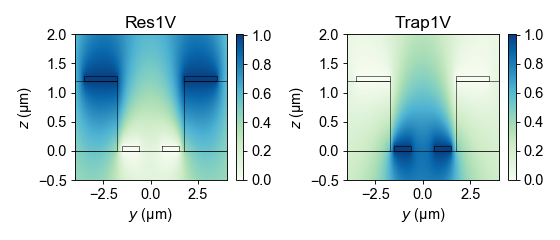

In [532]:
datapath = r"S:\_Data\190321 - EonHe Sweet Spot Simulations\2D Trap simulation results"
name = r"18_M019_2D_Trap_Simulation" # Without .dsp
output = load_ss_data(datapath, name)

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


We estimate the electron is roughly  75.26190476190467  nm below the ground plane
Evaluating potentials at z =  1.005 um


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


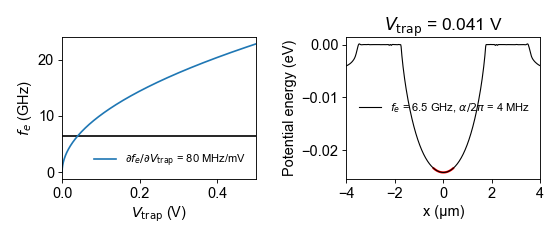

0.0405405405405


In [530]:
%matplotlib notebook
d0 = 1.0E-6 + 80E-9 # Top of the ground plane
w = 4.0E-6 # Channel width
f0 = 6.5
Vres = 0.00

Vtrap = get_resonance_condition(Vres, d0, w, f0, output, Vtrap_sweep=np.linspace(0.00, 0.5, 1e3))
print(Vtrap)

0.0 0.0405405405405
We estimate the electron is roughly  75.26190476190467  nm below the ground plane


<IPython.core.display.Javascript object>


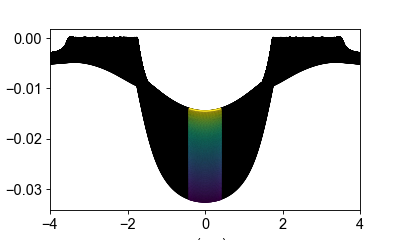

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


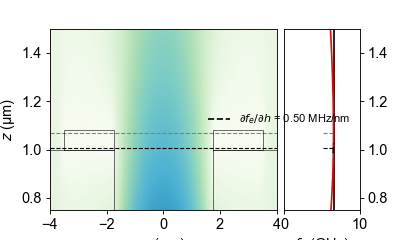

Sweet spot coordinate is z =  1.0685 um
Electron is  -63.7619047619 nm above the sweet spot


In [531]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt

print(Vres, Vtrap)
analyze_ss_data(datapath, name, output, d0, w, f0, Vres, Vtrap, xzoom=(0, 10), yzoom=(0.75, 1.5))

In [442]:
(5E6)**2 / (15E9)

1666.6666666666667

In [444]:
np.arctan(1.7E3/100E3) * 180/np.pi

0.9739344366011552